# Churn Prediction Report


In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.svm import SVC


from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from collections import Counter
from sklearn.preprocessing import StandardScaler

import plot_roc_curve as roc_curve_plot
import functions

from importlib import reload



***

# Background

A ride-sharing company (Company X) is interested in **predicting rider retention**. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an account in **January 2014**. The data was pulled on July 1, 2014; we consider a user retained if they were **“active”** (i.e. took a trip) in the preceding 30 days (from the day the data was pulled). In other words, a user is "active" if they have taken a trip since June 1, 2014. 


The data, churn.csv, is in the data folder. The data are split into train and test sets. You are encouraged to tune and estimate your model's performance on the train set, then see how it does on the unseen data in the test set at the end.



***

# Objective

We would like you to use this data set to help understand **what factors are the best predictors for retention**, and offer suggestions to operationalize those insights to help Company X. Therefore, your task is not only to build a model that minimizes error, but also a model that allows you to interpret the factors that contributed to your predictions.


***

Here is a detailed description of the data:

- city: city this user signed up in phone: primary device for this user
- signup_date: date of account registration; in the form YYYYMMDD
- last_trip_date: the last time this user completed a trip; in the form YYYYMMDD
- avg_dist: the average distance (in miles) per trip taken in the first 30 days after signup
- avg_rating_by_driver: the rider’s average rating over all of their trips
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips
- trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
- luxury_car_user: TRUE if the user took a luxury car in their first 30 days; FALSE otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday

## EDA

In [2]:
train = pd.read_csv("data/churn_train.csv", parse_dates= ['last_trip_date','signup_date'])

In [3]:
train.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0


In [4]:
train.tail()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
39995,2.06,4.8,4.3,1.08,Winterfell,2014-04-02,Android,2014-01-26,9.5,8,False,90.5
39996,2.05,5.0,5.0,1.00,King's Landing,2014-05-09,iPhone,2014-01-08,0.0,2,False,85.7
39997,3.04,5.0,5.0,1.00,Winterfell,2014-06-24,Android,2014-01-04,0.0,3,True,33.3
39998,3.49,4.3,3.3,1.50,Astapor,2014-02-09,iPhone,2014-01-08,40.0,5,False,60.0
39999,4.25,4.7,5.0,1.00,Astapor,2014-06-27,iPhone,2014-01-18,0.0,2,True,42.9


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
avg_dist                  40000 non-null float64
avg_rating_by_driver      39838 non-null float64
avg_rating_of_driver      33472 non-null float64
avg_surge                 40000 non-null float64
city                      40000 non-null object
last_trip_date            40000 non-null datetime64[ns]
phone                     39681 non-null object
signup_date               40000 non-null datetime64[ns]
surge_pct                 40000 non-null float64
trips_in_first_30_days    40000 non-null int64
luxury_car_user           40000 non-null bool
weekday_pct               40000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 3.4+ MB


***

## Feature engineering

### Create our target label

In [6]:
def add_target(df):
    '''
    Returns a data frame with a column added called within_last 30 days
    where 1 means the last ride was greater than 30 days away
    and 0 means the last ride was less than 30 days
    
    (ie.
    1 => CHURN
    0 => NO CHURN)
    
    '''
    df_copy = df.copy()
    
    latest_date = max(df_copy['last_trip_date'])
    
    time_diff = (latest_date - df_copy['last_trip_date'])
    churn = (time_diff > timedelta(days = 30)) * 1
    df_copy['churn'] = churn
    
    return df_copy

In [7]:
train = add_target(train)

In [8]:
train.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0,1
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0,1
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0,1
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0,1
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0,1


## Data cleaning

### Handling Nan values

In [9]:
def clean_avg_rating_of_driver(df):
    '''
    Cleaning the 'avg_rating_of_driver' column and creating 3 new columns:
        1. Column where we replace all np.nan to the median.
        2. Column where we replace all np.nan to the mode.
        3. Column where we replace all np.nan to the mean.
        4. Column where we create a scaled version of original
           while replacing all np.nan to median.
    '''

    df_copy = df.copy()

    # Create cleaned column replacing np.nan to median.
    median = df_copy.avg_rating_of_driver.median()
    df_copy['avg_rating_of_driver_median'] = df_copy.avg_rating_by_driver.fillna(median)

    
    # Normalized column based off median
    size = df_copy['avg_rating_of_driver_median'].shape[0]
    scaler = StandardScaler()
    df_copy['avg_rating_of_driver_normalized'] = scaler.fit_transform(df_copy['avg_rating_of_driver_median']\
                                                        .values.reshape(size,1))

    return df_copy


In [10]:
train = clean_avg_rating_of_driver(train)

In [11]:
def cleaning_avg_rating_by_driver(df):


    df_copy = df.copy()

    #create cleaned column replacing np.nan to median.
    median = df_copy['avg_rating_by_driver'].median()
    df_copy['rating_by_driver_median'] = df_copy.avg_rating_by_driver.fillna(median)

    # Normalized column based off median
    size = df_copy['rating_by_driver_median'].shape[0]
    scaler = StandardScaler()

    df_copy['rating_by_driver_median_normalized'] = scaler.fit_transform(df_copy['rating_by_driver_median']\
                                                                         .values.reshape(size,1))

    return df_copy


In [12]:
train = cleaning_avg_rating_by_driver(train)

### Outliers

0.0

160.96

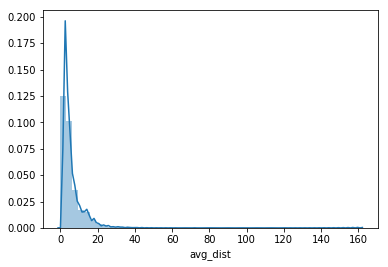

In [13]:
sns.distplot(train.avg_dist);
display(min(train.avg_dist), max(train.avg_dist))

In [14]:
train[train.avg_dist == 0].head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn,avg_rating_of_driver_median,avg_rating_of_driver_normalized,rating_by_driver_median,rating_by_driver_median_normalized
403,0.0,5.0,NaN,3.0,Astapor,2014-01-26,iPhone,2014-01-16,100.0,1,False,0.0,1,5.0,0.496532,5.0,0.495454
579,0.0,5.0,NaN,1.0,Winterfell,2014-06-05,iPhone,2014-01-20,0.0,0,False,100.0,0,5.0,0.496532,5.0,0.495454
826,0.0,5.0,NaN,1.0,Astapor,2014-02-01,Android,2014-01-27,0.0,1,False,100.0,1,5.0,0.496532,5.0,0.495454
1108,0.0,3.0,5.0,1.0,Astapor,2014-02-17,iPhone,2014-01-01,0.0,0,False,0.0,1,3.0,-3.975320,3.0,-3.974842
1667,0.0,5.0,5.0,1.0,Winterfell,2014-01-11,Android,2014-01-10,0.0,1,False,100.0,1,5.0,0.496532,5.0,0.495454


Should remove all 0 miles and more than 120 miles. I pick 120 mile as the threshold because taking the LA-San Diego example, 2 hours and 120 miles. Hence assume, a reasonable ride should not exceed 120 miles.

In [15]:
def avg_dist_clean(df):
    
    df_copy = df.copy()
    df_copy.drop(df_copy[df_copy.avg_dist == 0].index, inplace = True)
    
    return df_copy

In [16]:
train = avg_dist_clean(train)

We can see that there's a big concentration of churn when users only completed 0 or 1 trip in their first 30 days. As the number of trips going up, the rate of churn declines. 


## Categorical variables

In [18]:
train.city.unique()

array(['Astapor', 'Winterfell', "King's Landing"], dtype=object)

In [19]:
def dummify_city(df):

    """
    Input: DataFrame
    New columns, the 'city' column to dummy values
    New column, the 'city' column converted to integers
    Output: DataFrame
    """

    df_copy = df.copy()

    # Duplcate, sacrifical 'city' column
    #working_df['raw_city'] = working_df['city']

    # Make Dummy Columns
    new_df = pd.get_dummies(df_copy, columns=['city'], drop_first=True)


    return new_df

In [20]:
def dummify_phone(df):
    
    df_copy = df.copy()
    
    new_df = pd.get_dummies(df_copy, columns=['phone'])
    return new_df

In [21]:
train = dummify_city(train);

In [22]:
train = dummify_phone(train);

In [23]:
train.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn,avg_rating_of_driver_median,avg_rating_of_driver_normalized,rating_by_driver_median,rating_by_driver_median_normalized,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,6.94,5.0,5.0,1.00,2014-05-03,2014-01-12,0.0,0,False,100.0,1,5.0,0.496532,5.0,0.495454,0,0,1,0
1,8.06,5.0,5.0,1.00,2014-01-26,2014-01-25,0.0,2,True,0.0,1,5.0,0.496532,5.0,0.495454,0,0,1,0
2,21.50,4.0,NaN,1.00,2014-05-21,2014-01-02,0.0,1,True,100.0,1,4.0,-1.739394,4.0,-1.739694,0,1,0,1
3,9.46,5.0,NaN,2.75,2014-01-10,2014-01-09,100.0,1,False,100.0,1,5.0,0.496532,5.0,0.495454,0,1,1,0
4,13.77,5.0,NaN,1.00,2014-05-13,2014-01-31,0.0,0,False,100.0,1,5.0,0.496532,5.0,0.495454,0,1,0,1


***

# Baseline

In [24]:
target = train.churn

In [25]:
print("The percentage of the dataset who churn or non-active in the last 30 days {:.2f}%" \
      .format(sum(target)/len(target)*100))

The percentage of the dataset who churn or non-active in the last 30 days 62.34%


if we are only predicting if they used the service in the last 30 days, to be making predictions that are useful, we need to predict better than 62%

In [26]:
#train.phone.unique()

***

# Random Forest (M1)

In [27]:
train.columns

Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'last_trip_date', 'signup_date', 'surge_pct', 'trips_in_first_30_days',
       'luxury_car_user', 'weekday_pct', 'churn',
       'avg_rating_of_driver_median', 'avg_rating_of_driver_normalized',
       'rating_by_driver_median', 'rating_by_driver_median_normalized',
       'city_King's Landing', 'city_Winterfell', 'phone_Android',
       'phone_iPhone'],
      dtype='object')

In [28]:
#Set up the Data
selected_coln = ['avg_dist', 'rating_by_driver_median_normalized', 
                 'avg_rating_of_driver_normalized', 'phone_iPhone',
                 'phone_Android',
                 'avg_surge','surge_pct','trips_in_first_30_days', 
                 'luxury_car_user', 'weekday_pct', 
                 "city_King's Landing", "city_Winterfell"]

df = train[selected_coln]
X = df.values
y = target
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.33, random_state=42)



In [29]:
#Train the Model
model = RandomForestClassifier(n_estimators=50)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

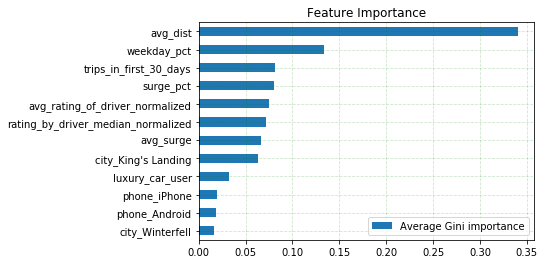



Accuracy =  75.06838905775076 %


In [30]:
#get the feature scores
feat_scores = pd.DataFrame({'Average Gini importance' : model.feature_importances_},
                           index=df.columns)
feat_scores = feat_scores.sort_values(by='Average Gini importance')

#Plot
feat_scores.plot(kind='barh');
plt.grid(alpha = .2,color = 'g',ls = '--')
plt.title('Feature Importance')
plt.show()
print("\n")
print('Accuracy = ', np.sum(model.predict(X_test) == y_test)/len(y_test)*100,'%')

***

# Train different models

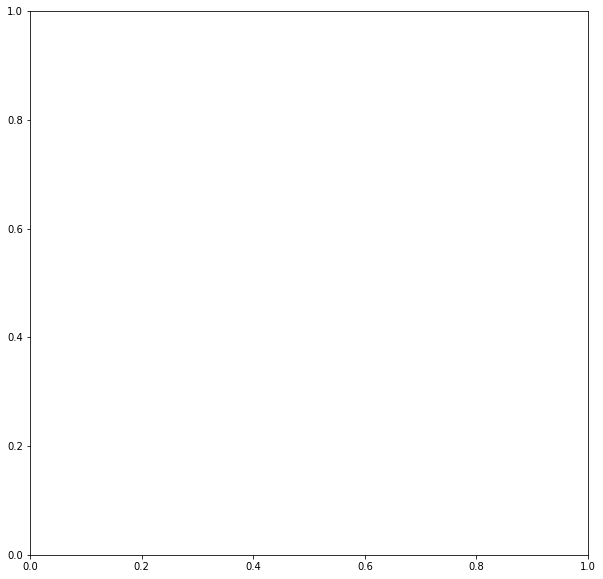

In [32]:
reload(roc_curve_plot)
_,ax = plt.subplots(1,1,figsize = (10,10))
models = [RandomForestClassifier(n_estimators=50), LogisticRegression(), \
          GradientBoostingClassifier(),AdaBoostClassifier(GradientBoostingClassifier(),\
                                                          learning_rate=1)]                                             
#roc_curve_plot.plot_roc(X,y,models,ax)

In [37]:
cost_matrix = np.array([[200, -100], [ 0,   0]]).T


In [39]:
reload(functions)
for model in models:
    
    m,profits,p = functions.plot_profit_curve(model, cost_matrix, X_train, X_test,\
                      y_train, y_test,ax)
    
    print('The percentage of correct classification for \nmodel:',
          model.__class__.__name__,
          'is: ',
          np.round(np.sum(m == y_test)/len(y_test)*100,3),
         '%')
    print('-'*50)

The percentage of correct classification for 
model: RandomForestClassifier is:  75.129 %
--------------------------------------------------
The percentage of correct classification for 
model: LogisticRegression is:  72.234 %
--------------------------------------------------
The percentage of correct classification for 
model: GradientBoostingClassifier is:  79.065 %
--------------------------------------------------
The percentage of correct classification for 
model: AdaBoostClassifier is:  78.374 %
--------------------------------------------------


## Model selection

We selected the GradientBoostingClassifier and train the model

In [43]:
final_model = GradientBoostingClassifier()
final_model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [44]:
#predictions = final_model.predict(X_test)

In [45]:
y_score = final_model.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.90


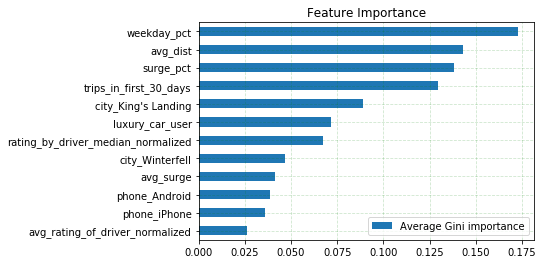



Accuracy =  79.06534954407294 %


In [47]:
feat_scores = pd.DataFrame({'Average Gini importance' : final_model.feature_importances_},
                           index=df.columns)
feat_scores = feat_scores.sort_values(by='Average Gini importance')

#Plot
feat_scores.plot(kind='barh');
plt.grid(alpha = .2,color = 'g',ls = '--')
plt.title('Feature Importance')
plt.show()
print("\n")
print('Accuracy = ', np.sum(final_model.predict(X_test) == y_test)/len(y_test)*100,'%')

Accuracy score is now 79%! That is **27%** better than predicting the majority class

The top three factors are:

- weekday_pct
- avg_dist
- surge_pct

In [70]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot()
ax1.sns.distplot(train[train.churn == 0].weekday_pct, bins = 20, kde=False, label = 'weekday_pct no churn')
#sns.distplot(train[train.churn == 1].weekday_pct, bins = 20, kde=False, label = 'weekday_pct churn')
plt.show()

AttributeError: 'NoneType' object has no attribute 'sns'

<Figure size 864x432 with 0 Axes>

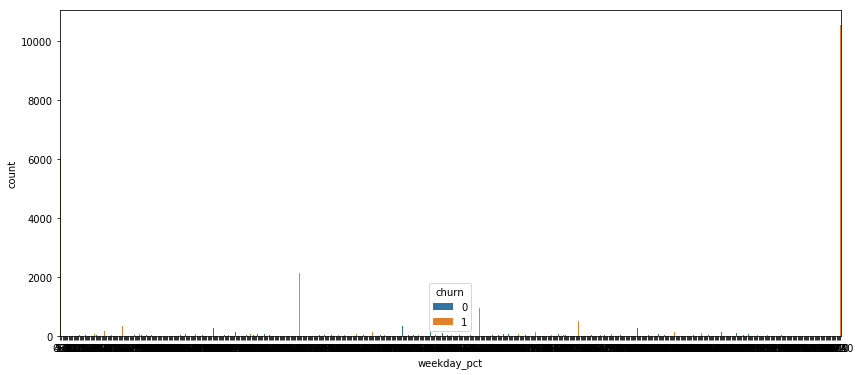

In [52]:
plt.figure(figsize=(14, 6))
sns.distplot(x="weekday_pct", hue="churn", data=train)
#sns.coauntplot(x="weekday_pct", hue="churn", data=train)
plt.show()